In [314]:
import pandas as pd
import numpy as np
import os
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Dropout


from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

In [315]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [316]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [317]:
#importing HDFC stock price dataset till 2021 April
dataset=pd.read_csv('/content/gdrive/My Drive/datasets/HDFC.csv')

In [318]:
# Dataset of HDFC closing prices only
df=dataset.copy()

In [319]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [320]:
df=df.iloc[:,[0,9]]

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5306 non-null   object 
 1   VWAP    5306 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.0+ KB


In [322]:
df['Date'] = pd.to_datetime(df['Date'])

In [323]:
df.set_index("Date",  inplace=True)

<Axes: xlabel='Date'>

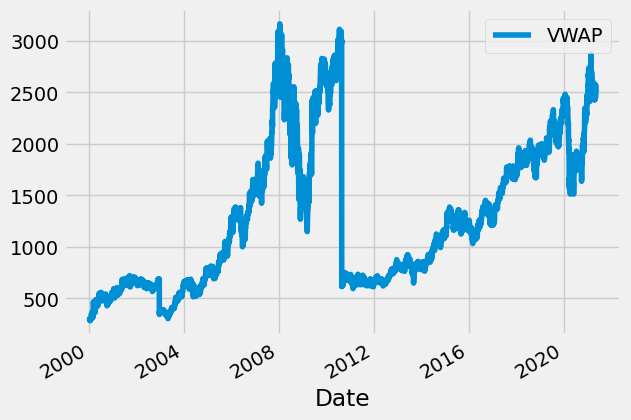

In [324]:
df.plot(xlabel = 'Date')

In [325]:
# Checking for null values in dataset
df.head()
df1=df.copy()
df1.head()

,VWAP
Date,
2000-01-03,293.50
2000-01-04,303.62
2000-01-05,294.53
2000-01-06,300.14
2000-01-07,288.80


In [326]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [327]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [328]:
scaler = RobustScaler()
df = scaler.fit_transform(df)

In [329]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid

In [332]:
# use 100 historical observations, predict 1 step ahead
look_back = 100
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

(5205, 100) (5205, 1)


In [333]:
# Our prepare_split function takes care of reshaping the data into [batch size, time steps, dimensionality]

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)
print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(5000, 100, 1) (205, 100, 1) (5000, 1) (205, 1)


In [371]:
def create_model():

    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

model1 = create_model()

In [383]:
def create_model1():

    model=Sequential()
    model.add(LSTM(20,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

model1 = create_model1()
model1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, None, 20)          1760      
                                                                 
 lstm_54 (LSTM)              (None, 10)                1240      
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [384]:
model1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, None, 20)          1760      
                                                                 
 lstm_54 (LSTM)              (None, 10)                1240      
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [385]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
                  epochs = 100, batch_size = 30, callbacks=[early_stop])

Epoch 1/100
167/167 [==============================] - 6s 17ms/step - loss: 0.0585 - val_loss: 0.0094
Epoch 2/100
167/167 [==============================] - 2s 14ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 3/100
167/167 [==============================] - 2s 10ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 4/100
167/167 [==============================] - 2s 10ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 5/100
167/167 [==============================] - 2s 11ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 6/100
167/167 [==============================] - 2s 11ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/100
167/167 [==============================] - 2s 11ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/100
167/167 [==============================] - 2s 11ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 9/100
167/167 [==============================] - 2s 15ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 10/100
167/167 [==============================] - 2s 12ms/step - loss: 0.003

In [386]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

7/7 [==============================] - 1s 5ms/step


In [387]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 42.0006


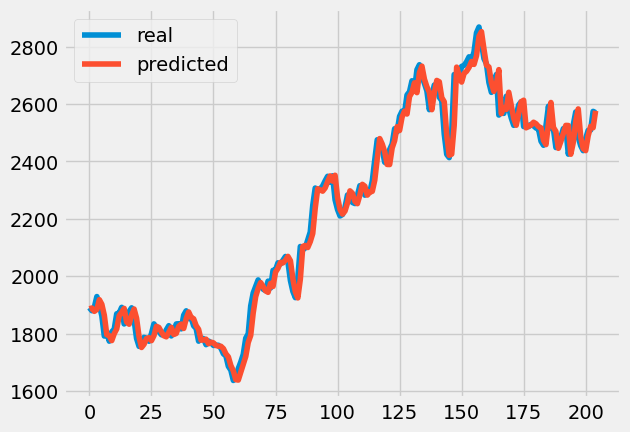

In [388]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [397]:
x_input = df[5206:].reshape(1,-1)
x_input.shape

(1, 100)

In [398]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [399]:
# Predicting next 20 days closing price of the stock
lst_output=[]
n_steps=100
nextNumberOfDays = 20
i=0

while(i<nextNumberOfDays):

    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[1.1383853]
101
1 day input [0.97640839 1.00145616 1.03097301 1.02481601 1.0019984  1.01355151
 1.0111202  1.04525479 1.10950967 1.17075602 1.15705146 1.14200006
 1.10231193 1.09879615 1.14081939 1.15766367 1.20435712 1.19471933
 1.24192878 1.25783727 1.25211756 1.30723316 1.31692343 1.35043707
 1.32082402 1.38414312 1.39918577 1.36463139 1.34266211 1.31960837
 1.26231508 1.30633235 1.33734471 1.34021331 1.300394   1.28975919
 1.18788017 1.1261528  1.1163226  1.19001412 1.36933659 1.35636667
 1.364404   1.39406077 1.39710429 1.40803645 1.42335023 1.41272416
 1.43860278 1.49628088 1.51406095 1.46693895 1.41795411 1.40235173
 1.34520712 1.31511306 1.32820542 1.36946778 1.2458906  1.2697577
 1.25100685 1.30312266 1.26599704 1.23724107 1.21466834 1.24418518
 1.27672805 1.28640083 1.21088144 1.21819287 1.21057534 1.21760691
 1.21317282 1.20646484 1.20353502 1.16626946 1.1539992  1.21352265
 1.27308982 1.20531915 1.20408601 1.14702886 1.16435415 1.17925688
 1.20454078 1.20765426 1.12688744 1

In [400]:
day_new = np.arange(1,101)
day_pred = np.arange(101,121)

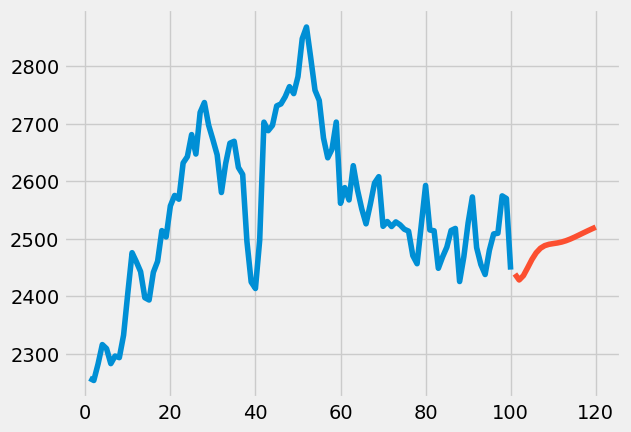

In [401]:
# Plotting the prediction for next 50 days
plt.plot(day_new, scaler.inverse_transform(df[5206:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

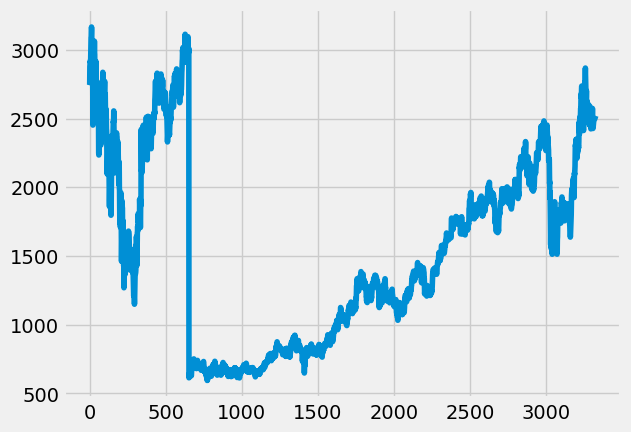

In [402]:
df3 = df.tolist()
df3.extend(lst_output)
plt.plot(scaler.inverse_transform(df3[2000:]))